# Introduction to PyTorch

Credit: Jake Austin, Aryan Jain, Rohan Viswanathan, Stanford CS 231N

In this notebook, we will learn about PyTorch, a deep learning framework that will allow us to quickly implement and train models.

At the end of the day, **deep learning is just math** that we could implement with some barebones library like NumPy, but that would take forever and not scale well. So we use libraries like PyTorch to abstract away these details, and use prebuilt tools for designing networks and training them without too much code.

We will use Colab for this tutorial since the GPUs are free.

**We will assume proficiency with basic python and numpy** (see [here](https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=Numpy) for a basic introduction to numpy and its syntax... and some basic python review).


### What is PyTorch?

PyTorch works exactly like numpy but it also keeps track, on the fly, of all the operations we perform with Tensor objects (which behave like numpy ndarrays). It caches everything it needs to calculate arbitrary derivatives of any scalar function with respect to any element of any tensor that was used in the computation for that scalar function (in other words, you will be able to calculate the derivative of anything with respect to anything). This is an enormous step up from the dinosaur days of having to calculate and plug in your own derivatives to layers of neural networks.

### Why?

* Small code footprint, but incredibly powerful
* Our code will now run on GPUs without us having to touch CUDA ourselves directly
* PyTorch is used everywhere in research and in industry


## How will I learn PyTorch?

PyTorch has an excellent series of tutorials [here](https://pytorch.org/tutorials/).

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch.

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. In general the PyTorch documentation is incredibly comprehensive and should be referenced / searched wherever possible if you have a question on how some function works.


# Table of Contents

This assignment has 6 parts. We will start by talking about PyTorch and its similarities to numpy. We will then move on to talking about PyTorch's automatic differentiation engine. We will quickly go over APIs and function calls for loading datasets. Finally, we will show 3 different levels of abstraction that can be used for creating neural networks.

1. Numpy / Torch
2. Automatic Differentiation
3. Datasets / Dataloaders / Augmentations
4. Barebones PyTorch (Low level network design)
5. nn.Module PyTorch (Middle level network design)
6. nn.Sequential PyTorch (High level network design)

Here is a table of comparison for each abstraction level:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# 1. Numpy / Torch

In this section we are going to show you some of the similarities between numpy and pytorch.

PyTorch is based around `Tensor()` objects. They behave exactly like numpy arrays in terms of what they are and what you can do with them. Just as basic ndarrays with floating point numbers are just higher dimensional generalizations of matrices, tensors are no different. These tensors are created as the returned value from ``torch.tensor(data)`` where ``data`` is a (optionally nested) list of integers or floats or booleans, or even ndarrays/other tensors themselves!

Like numpy, pytorch has a lot of mathmatical operations that can be performed on tensors... such as addition, elementwise multiplication, matrix multiplication, etc.

This cannot be stressed enough, ignoring what's going on under the hood, tensors behave EXACTLY like ndarrays, so there is nothing to fear!

This similarity is demonstrated again in [this](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) pytorch tutorial.

## Numpy PyTorch Similarities

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The most basic way to create tensors is to just pass nested lists into a `torch.tensor()` function call. Here, we will create the 2x2 identity matrix from a nested list.

In [3]:
data_a = [[1.,0.], [0., 1.]]
np_a = np.array(data_a)
torch_a = torch.tensor(data_a)


print('Numpy Array Contents and type:')
print('np array: \n', np_a, '\n', type(np_a), '\n', np_a.shape, '\n')
print('Torch Tensor Contents and type:')
print('torch tensor: \n', torch_a, '\n', type(np_a), '\n', torch_a.shape)


Numpy Array Contents and type:
np array: 
 [[1. 0.]
 [0. 1.]] 
 <class 'numpy.ndarray'> 
 (2, 2) 

Torch Tensor Contents and type:
torch tensor: 
 tensor([[1., 0.],
        [0., 1.]]) 
 <class 'numpy.ndarray'> 
 torch.Size([2, 2])


We can see that even indexing into these objects works the same way!

In [4]:
print('Indexing at (i, j) = (1, 1)')
print(np_a[1, 1], type(np_a[1, 1]))
print(torch_a[1, 1], type(torch_a[1, 1]))

Indexing at (i, j) = (1, 1)
1.0 <class 'numpy.float64'>
tensor(1.) <class 'torch.Tensor'>


We can reshape our arrays in similar ways too.

PyTorch's [view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) is analogous to numpy's [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) method: it reshapes a tensor's dimensions according to the arguments of the function.

As an example, say we want to take a tensor of shape `2 x 3 x 3` and reshape it into a `2 x 9` tensor. The output tensor will have its elements laid out accordingly:

```python
input[0, 0, 0] == output[0, 0]
input[0, 0, 1] == output[0, 1]
input[0, 0, 2] == output[0, 2]
# After this, we increment on the next dimension
# of the input tensor since the last two dimensions
# are only 3 long
input[0, 1, 0] == output[0, 3]
...
input[0, 2, 2] == output[0, 8]
input[1, 0, 0] == output[1, 0]
...
input[1, 2, 2] == output[1, 8]
```

Basically, if you were to iterate over every element in the tensors (before and after reshaping) starting with the last dimensions first, the order of the elements printed is the same for both tensors.

PyTorch additionally has another [reshape](https://pytorch.org/docs/stable/generated/torch.reshape.html) method available: the main difference between the two is that `.reshape` *might* copy the underlying data of a tensor into a new tensor (you can find a more comprehensive comparison [here](https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch)). For most purposes, you should be able to use `view` and `reshape` interchangeably.

In [5]:
start = torch.zeros((2, 3, 3))
idx = 0
for i in range(start.shape[0]):
    for j in range(start.shape[1]):
        for k in range(start.shape[2]):
            start[i, j, k] = idx
            idx += 1
print("Before reshaping:")
print(start)
end = start.view(2, 9)
print("After reshaping")
print(end)
print()

print(start[0, 0, 0], end[0, 0])
print(start[0, 0, 1], end[0, 1])
print(start[0, 0, 2], end[0, 2])
print(start[0, 1, 0], end[0, 3])
print('...')
print(start[0, 2, 2], end[0, 8])
print(start[1, 0, 0], end[1, 0])
print('...')
print(start[1, 2, 2], end[1, 8])

Before reshaping:
tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.]],

        [[ 9., 10., 11.],
         [12., 13., 14.],
         [15., 16., 17.]]])
After reshaping
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12., 13., 14., 15., 16., 17.]])

tensor(0.) tensor(0.)
tensor(1.) tensor(1.)
tensor(2.) tensor(2.)
tensor(3.) tensor(3.)
...
tensor(8.) tensor(8.)
tensor(9.) tensor(9.)
...
tensor(17.) tensor(17.)


We can see that numpy arrays and pytorch tensors have the same types of operations associated with them. They all support + (addition), - (subtraction), * (elementwise multiplication), @ (matrix multiplication where the operands are matrices), and even truth operations like == and >= (virtually, any syntax that works with numpy arrays will most likely work with pytorch tensors as well).

In [6]:
data_b = [[1., 1.], [1., 1.]]
np_b = np.array(data_b)
torch_b = torch.tensor(data_b)

print('Matrix a\n', np_a, '\nMatrix b\n', np_b, '\n')

print('----------------------')
print('Addition (a + b)')
print('numpy array: \n', np_a + np_b)
print('torch tensor: \n', torch_a + torch_b)
print()

print('----------------------')
print('Subtraction (a - b)')
print('numpy array: \n', np_a - np_b)
print('torch tensor: \n', torch_a - torch_b)
print()

print('----------------------')
print('Elementwise Multiplication (a * b)')
print('numpy array: \n', np_a * np_b)
print('torch tensor: \n', torch_a * torch_b)
print()

print('----------------------')
print('Matrix Multiplication (a @ b)')
print('numpy array: \n', np_a @ np_b)
print('torch tensor: \n', torch_a @ torch_b)
print()


Matrix a
 [[1. 0.]
 [0. 1.]] 
Matrix b
 [[1. 1.]
 [1. 1.]] 

----------------------
Addition (a + b)
numpy array: 
 [[2. 1.]
 [1. 2.]]
torch tensor: 
 tensor([[2., 1.],
        [1., 2.]])

----------------------
Subtraction (a - b)
numpy array: 
 [[ 0. -1.]
 [-1.  0.]]
torch tensor: 
 tensor([[ 0., -1.],
        [-1.,  0.]])

----------------------
Elementwise Multiplication (a * b)
numpy array: 
 [[1. 0.]
 [0. 1.]]
torch tensor: 
 tensor([[1., 0.],
        [0., 1.]])

----------------------
Matrix Multiplication (a @ b)
numpy array: 
 [[1. 1.]
 [1. 1.]]
torch tensor: 
 tensor([[1., 1.],
        [1., 1.]])



PyTorch even supports some of the linear algebra operations that numpy supports! Not all of them share the same function names, but the ones below do. Here, we only show the functions for calculating norms and inverses, but just like numpy, torch has functionality for everything from QR decompositions to SVD to solving systems of linear equations.

In [7]:
print('Norm -------------------------')
data_v = [0.6, 0.8]
np_v = np.array(data_v)
torch_v = torch.tensor(data_v)
print('numpy array: \n', np.linalg.norm(np_v))
print('torch tensor: \n', torch.linalg.norm(torch_v))
print()

print('Inverse ---------------------')
data_M = [[0.4, 0.3], [-0.3, 0.4]]
np_M = np.array(data_M)
torch_M = torch.tensor(data_M)
print('numpay array: \n', np.linalg.inv(np_M))
print('torch tensor: \n', torch.linalg.inv(torch_M))

Norm -------------------------
numpy array: 
 1.0
torch tensor: 
 tensor(1.)

Inverse ---------------------
numpay array: 
 [[ 1.6 -1.2]
 [ 1.2  1.6]]
torch tensor: 
 tensor([[ 1.6000, -1.2000],
        [ 1.2000,  1.6000]])


Finally, we can also convert back and forth between tensors and ndarrays. We can call ``torch.tensor()`` on an ndarray to receive it as a tensor, or call ``.numpy()`` on a tensor to get the numpy version of it.

In [8]:
print(torch.tensor(np_a))
print(torch_a.numpy())

tensor([[1., 0.],
        [0., 1.]], dtype=torch.float64)
[[1. 0.]
 [0. 1.]]


## Devices

Here is one of the major differences between pytorch and numpy: GPUs. In the code block below, we will define a "device" as the object returned by calling ``torch.device('cuda')`` or ``torch.device('cpu')``. These objects can be then passed into new tensors that we create, indicating what hardware device they should be stored on. You can also move around existing tensors across devices by using the ``.to()`` function: calling ``x.to(device)`` on tensor ``x`` will move it to the specified device.

You have an option to **use the GPU by setting the ``USE_GPU`` flag to True below**. It is recommended, but not necessary to use a GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fall back to CPU mode. The global variables `dtype` and `device` will control the data types throughout this assignment.

If you are using Colab, you need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [9]:
USE_GPU = True

dtype = torch.float32 # we will use the float32 data type throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Here, we see a tensor created with a device from the get go, and another example where we send an existing tensor to a device. If you indeed do have a GPU enabled, you should see ``'cuda:0'`` listed as the device type for these tensors. **The last example shouldn't work because sending a tensor to a device with a ``.to()`` call returns the a NEW object that is stored on the new device... the ``.to()`` operation isn't an 'in place' operation!**

You will be using the ``.to()`` function on networks and tensors down the line to send entire neural networks and batches of data to a GPU during training!

In [10]:
a = torch.randn((2, 2), device = device)
print(a, a.device)

a = torch.randn((2, 2))
a = a.to(device)
print(a, a.device)

a = torch.randn((2, 2))
a.to(device)
print(a, a.device)

tensor([[-0.8023,  0.3245],
        [ 0.1652,  0.5353]], device='cuda:0') cuda:0
tensor([[ 2.3171, -0.8156],
        [-0.0216,  0.0158]], device='cuda:0') cuda:0
tensor([[-0.0117,  0.6891],
        [-0.4566, -0.6861]]) cpu


The following cell will error if your device is a GPU. This is because tensors not on the same device cannot be operated on together. This makes sense, because how on earth are you going to perform an arithmetic operation on tensors that are on separate hardware?

Let this be a cautionary tale down the line when you train your networks: if your network is on a GPU, make sure you send your batches of data to the GPU as well.

In [11]:
torch.randn((2, 2), device = device) + torch.randn((2, 2))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Feel free to comment out the line above once you have seen what the errors looks like!

# 2.  PyTorch Autograd

We have shown that, on the surface, torch tensors have the same functionality as numpy arrays, but under the hood, there is so much more going on! **We can specify that we want to take the derivatives of a tensor output with respect to the elements of a different tensor, when evaluated at specific points.** While torch won't be spitting out symbolic derivatives like ``f(x, w) = xw^2 ==> df/dw = 2wx``, it will evaluate ``df/dw`` at a specific value of ``x`` for a specific value of ``w``, which is all that we really need for deep learning.

**Please note that the only syntactical thing you should come away from this portion with is that ``x.backward()`` will calculate the partial derivatives of every tensor with respect to ``x``.** You will never have to go in and look at what a tensor's ``.grad`` attribute is... we will using something called Optimizers later on that will handle the gradient updates for us automatically. The ``.float()`` casting (which, as the name suggests, converts a tensor to the float data type) is probably useful to know as well.

For a specific pytorch tutorial on this subject of automatic differentiation, see [here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html).

In [12]:
import torch

Here we will start with a basic function, ``f(x, w) = xw^2``, as given in the example above. We will first set our value for ``w`` that we want to evaluate the derivative of ``f`` at.

Since we need to take the derivative of this function with respect to its inputs, we need a way to specify to torch to allow differentiation with respect to those inputs. For every tensor with respect to which we want to be able to differentiate a function with, we will set its ``.requires_grad`` field to True. This will ensure that after a computational graph is built and backpropagation has ran, those tensors will have an additional attribute storing their gradients!

Heads up: the following cell will throw an error!


In [13]:
#w = torch.tensor(5)
#w.requires_grad = True

Oh no! This is to be expected. Torch is telling us that in order to be able to differentiate with respect to something, that thing has to be a floating point number. This makes sense, because the derivative only works in a continuous space and integers are discrete (technically, floating point numbers are discrete too but they are the best representation of continuous real numbers that computers can understand). Feel free to comment out the cell above after you have seen what the error looks like.

This is an issue that will crop up and give you all kinds of trouble if you aren't careful, especially since we frequently load in images where pixel values are integers in the range [0 - 255].

Just to be safe, it is often a good idea just to cast things if you aren't certain what their type is.

In [14]:
w = w.float()
w.requires_grad = True

x = torch.tensor(4)

NameError: name 'w' is not defined

Now we will evaluate `y = f(x, w)` with our tensors. The magical thing about pytorch is that we really only need to specify how to evaluate the function, and pytorch will take care of the rest for us! So, we will go ahead and evaluate

In [ ]:
y = x * (w ** 2)
print(y, type(y))

You can see that ``f(x, w)`` has been evaluated correctly, since `x = 4` and `w = 5`. We can also see a `grad_fn` field in the tensor. It's not important what this is, but it should be clear that pytorch is already ahead of the curve, and is stashing all the information it needs for actually calculating derivatives later, which happens with a call to `.backward()` function.

The `a.backward()` function tells pytorch to go ahead and take the derivatives of `a` with respect to all the tensors that were used to create `a`. The outputs will be stashed in those tensors' `.grad` fields.

More generally, in the context of backpropagating for neural networks, **the `a.backward()` method only makes sense if the tensor `a` contains only a single scalar as opposed to a vector or matrix. Otherwise you are computing the derivative of a vector or matrix with respect to a scalar weight, which will yield another vector / matrix instead of a scalar.** Since the components of our weights are scalars, we want the derivatives of our loss with respect to those components to be scalars as well (so that we can perform a gradient descent step). This is why, when performing batched gradient descent, you will average the loss across training examples, yielding a single scalar loss for that batch that we can backpropagate on.

In [ ]:
y.backward()
print(w.grad)

Yay! This is what we should expect since ``df/dw = 2wx = 2(5)(4)`` when `w = 5` and `x = 4`. Let's see what happens if we run the same cell again but with a different value of `w`:

In [ ]:
w.data = torch.tensor(3.)
y = x * (w ** 2)
print(y)
y.backward()
print(w.grad)

What happened?!?!?! We can see that `y = f(4, 3) = 36.` evaluated correctly. This means that `df/dw` should have been `2(4)(3) = 24.` but we are seeing a `64.` in `w.grad` instead of a `24.`?

**Turns out that when pytorch computes the derivative of `y` with respect to `w`, it doesn't just overwrite the `.grad` attribute of `w`, but actually adds to it in place.** Our `.grad` attribute was initially `40.`, and when we performed another backward pass, the new derivative was `24.`: instead of overwriting to the new gradient, pytorch added to the previous `w.grad`
field. **This is why, after each batch of data you backpropagate on, you will need to clear your model's gradients.** We will tell you how to exactly do this later on, but let this be a cautionary tale to clear your gradients between gradient steps nonetheless.

This is something that is useful when performing "gradient accumulation" (out of scope for now, but something worth googling eventually).

More generally, we can actually create any function `f` that takes in arbitrary parameters, and still backpropagate from the output of the function to the inputs. Let's illustrate by creating a function called `f` which is our quadratic from earlier, but know that you can truly create any function so long as the operations inside are differentiable.

In [ ]:
# we should zero out the w.grad attribute to ensure we see the correct gradient this time
w.grad.zero_()

def f(w, x):
    return x * (w ** 2)


y = f(w, x)
y.backward()
print(w.grad)

At this point, you can use pytorch to calculate arbitrary derivatives evaluated at arbitrary values.

PyTorch has a [nice tutorial](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) that shows a more complex example with nice diagrams, and states in greater detail about how it actually keeps track of different tensor computations, and we recommend you check it out.

# 3. Datasets and Dataloading

One of the critical parts of training neural networks is dealing with data and knowing how to augment / transform it.

We will be using the `torch.utils.data` for the core of our dataloading pipeline, using it to create datasets and dataloaders. Moreover, the library `torchvision` (a subset of pytorch that contains utilities useful for computer vision tasks) will also be used for performing data augmentations.

The official torch intro to datasets and dataloaders is [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and the list of transforms (augmentations) in torchvision is available [here](https://pytorch.org/vision/stable/transforms.html).


In [15]:
# Some misc imports used for demonstrations
import matplotlib.pyplot as plt

# What we actually need for this to work
import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T

## Datasets

A dataset in PyTorch is any class inheriting from the `torch.utils.data.Dataset` parent class, with the following 3 methods:
1. ` __init___(self, ...):`
This is the initialization function where you can pass in whatever arguments you want for your custom dataset. Save all the information from the arguments in instance variables here so it will be easy to fetch them later in the methods given below.
2. ` __len__(self):`
Here, you simply need to return the length of your dataset (ie: the number of samples in the datasets).
3. ` __getitem__(self, idx):`
This is the meat of the dataset class. This is a function that must take in `self` and `idx` as arguments, but nothing else. Here, `idx` will be an integer between 0 (inclusive) and the length of your dataset (exclusive). You should be returning the tensor(s) corresponding to the `idx`-th training example (transformed / augmented if you so desire), and any other data you may want (like a label or any relevant metadata). Most of the time, for image data, this involves: opening an image file -> converting it to a tensor -> applying any augmentations -> outputting the final image and its corresponding label.

Below is what your dataset will look like written out in skeleton code.


In [16]:
class custom_dataset(Dataset):
    def __init__(self, **kwargs):
        pass # Insert your code here to initialize the dataset and load up what you need

    def __getitem__(self, idx):
        pass # Figure out how to load up and return the idx-th item in the dataset
        return x, label, other_misc_information_you_may_want

    def __len__(self):
        pass # Return the length of the dataset

Let's make a toy dataset where the `(x, y)` pairs are `(x, sin(x))` respectively... i.e., our dataset is just inputs and outputs of the sine function.

In [17]:
class sin_dataset(Dataset):
    def __init__(self, num_examples, x_range):
        """
        Documentation here:
        num_examples is the number of examples we want this dataset to have
        x_range is a tuple of (lowest_possible_x, highest_possible_x)
        """
        self.num_examples = num_examples
        # torch.rand(shape) outputs a tensor with shape `shape` whose entries are uniformly distributed in the range [0, 1)
        self.x_vals = (torch.rand(num_examples) * (x_range[1] - x_range[0])) + x_range[0]

    def __getitem__(self, idx):
        return self.x_vals[idx], torch.sin(self.x_vals[idx])

    def __len__(self):
        return self.num_examples

We can index into this dataset directly once we instantiate a sin_dataset object, and can even iterate over it!

This creates a super convenient way to pass data around, adding a nice structured abstraction to the process of getting and loading in data.

0-th entry (tensor(1.6187), tensor(0.9989))
1-th entry (tensor(-1.3866), tensor(-0.9831))


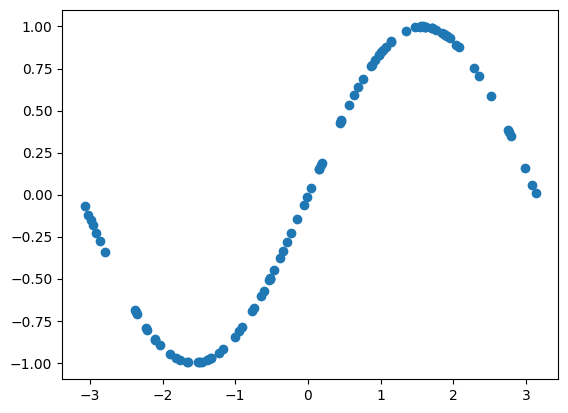

In [18]:
torch.manual_seed(1)  # Setting the seed just for reproduceability... can remove this if you want
ds = sin_dataset(100, (-torch.pi, torch.pi))

print('0-th entry', ds[0])
print('1-th entry', ds[1])

xs = []
ys = []
for x, y in ds:
  xs.append(x)
  ys.append(y)

plt.scatter(xs, ys)
plt.show()

## Dataloaders

Let's now learn about dataloaders. They simply wrap our dataset objects and batch our data for us, even shuffling it if we so want (we usually do!). They use multiprocessing under the hood to fetch our data quickly, providing one further abstraction away from the data loading process by allowing us to now directly request batches of data.

PyTorch's base `DataLoader()` class will automatically batch things for us. If our dataset spits out 4 tensors in the `getitem(self, idx)` function, then the dataloader with spit out (in the same order) 4 batched tensors of, where an extra dimension (the batch dimension) is added as the first dimension.

In the case of visual data, if your images are of size `C x H x W` (channels in the image, width, height), the dataloader will spit out a batch tensor of size `N x C x H x W` where `N` is the number of samples in the batch and `batch[i]` is the `i`th training example (since we indexed along the first dimension, which is the batch dimension)

We will not be covering ways to create your own dataloader since, so long as you are returning tensors, no matter how many, pytorch will almost always get the batching right. For more complex data, you may have to define your own batching functions (but this is typically more commonly done in NLP than CV).


In [19]:
# we want each batch to contain 10 samples
# since we set shuffle=False, the first batch will contain the first 10 samples (idx in range(0, 10)) of the dataset,
# the next batch will contain the next 10 samples (idx in range(10, 20)) and so on
loader = DataLoader(ds, batch_size=10, shuffle=False)

batch_x, batch_y = next(iter(loader))
print('Batched x', batch_x)
print('Batched y', batch_y)


for i, (x, y) in enumerate(ds):
    if i >= 10: # We only want the first 10
        break
    print('Example ' + str(i) + '     ', 'x: ', x, '    y: ', y)



Batched x tensor([ 1.6187, -1.3866, -0.6090,  1.4746, -2.9576,  1.8841, -0.6463,  1.5983,
         0.4367, -0.3847])
Batched y tensor([ 0.9989, -0.9831, -0.5721,  0.9954, -0.1829,  0.9513, -0.6022,  0.9996,
         0.4230, -0.3753])
Example 0      x:  tensor(1.6187)     y:  tensor(0.9989)
Example 1      x:  tensor(-1.3866)     y:  tensor(-0.9831)
Example 2      x:  tensor(-0.6090)     y:  tensor(-0.5721)
Example 3      x:  tensor(1.4746)     y:  tensor(0.9954)
Example 4      x:  tensor(-2.9576)     y:  tensor(-0.1829)
Example 5      x:  tensor(1.8841)     y:  tensor(0.9513)
Example 6      x:  tensor(-0.6463)     y:  tensor(-0.6022)
Example 7      x:  tensor(1.5983)     y:  tensor(0.9996)
Example 8      x:  tensor(0.4367)     y:  tensor(0.4230)
Example 9      x:  tensor(-0.3847)     y:  tensor(-0.3753)


What we did here is create an iterable (see [here](https://www.w3schools.com/python/python_iterators.asp) for a tutorial on python iterators) from our dataloader by calling `iter(loader)`. We retrieved its first element by calling `next()`, which spat out 2 tensors: a batched version of the first 10 `x` values and a batched version of the first 10 `y` values. The order is the same and the values are themselves unchanged as we can confirm by printing out the first 10 elements from the dataset by hand.

In your training loops, you will iterate over your dataloader by doing something like this:

```python
for batch in train_loader:
    x, label = batch
    # Insert one step of gradient descent here
```

## Image Transforms

One last thing you should know (before we load up a real dataset and move on) is how to transform / augment images. For this, we will usually use the transforms defined in `torchvision.transforms` (though, depending on the problem you are working on, you may have to define custom transformations). These will be objects that are callable on some data, returning the transformed version of said data.

Below we have an example of a basic transform: the `ToTensor()` transform. This is an object that will take in numpy arrays or PIL (another format for representing image files in python) images and spit out their tensor version.
Something to be cautious about: PIL or numpy images are represented with shapes `H x W x C` and `ToTensor()` will automatically transpose them to a shape of `C x H x W`, which is what pytorch prefers. Moreover, PIL or numpy images also tend to be integers in the range `[0, 255]` (each pixel is 1 bit), and `ToTensor()` scales them down to floats in the range `[0., 1.]`.

In [20]:
transform = T.ToTensor()

test = np.arange(256).reshape(16, 16).astype(np.uint8)
print('This is the original np array')
print(type(test))
print(test, '\n\n')

transformed = transform(test)
print('This is the transformed array')
print(type(transformed))
print(transformed)

This is the original np array
<class 'numpy.ndarray'>
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
 [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
 [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175]
 [176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191]
 [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207]
 [208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223]
 [224 22

You can see what we did and how this worked. We take the instantiated transform object, and then essentially treat it as a function by calling it on the data we want to transform. A little off the wall, but also pretty straightforward. We can do this with a whole host of transforms in the torchvision library found [here](https://pytorch.org/vision/stable/transforms.html) (one needs to be careful because some of the transforms only accept numpy arrays or PIL images as inputs, while other transforms only accept tensor objects as inputs). We will compose them in the example shown below, using `transforms.Compose`. For computer vision tasks, it is very useful to define image augmentations using the `torchvision.transforms` class in this way.

--2025-02-18 03:51:43--  https://upload.wikimedia.org/wikipedia/commons/c/c5/Peacock_Plumage.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1972892 (1.9M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.88M  --.-KB/s    in 0.1s    

2025-02-18 03:51:43 (13.4 MB/s) - ‘image.jpg’ saved [1972892/1972892]




This is our starting image


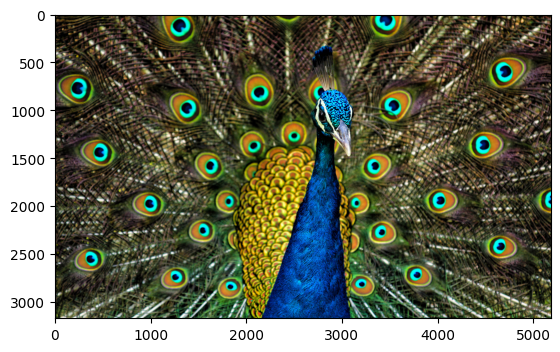

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


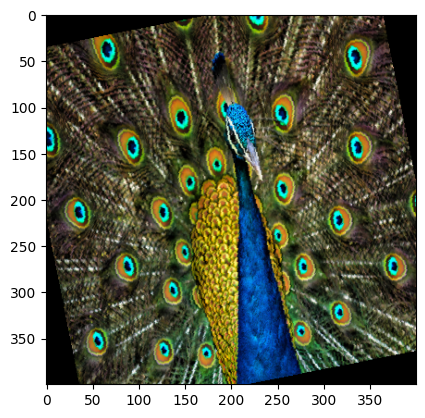

torch.Size([3, 400, 400])


In [21]:
# This gets us a dummy image to use
!wget -O image.jpg https://upload.wikimedia.org/wikipedia/commons/c/c5/Peacock_Plumage.jpg


img_as_np = plt.imread('image.jpg')

print('\n\n\nThis is our starting image')
plt.imshow(img_as_np)
plt.show()

transform = T.Compose([
                T.ToTensor(),
                T.Resize((400, 400)),
                T.RandomRotation(degrees=20)
            ])

output_tensor = transform(img_as_np)

plt.imshow(output_tensor.permute(1, 2, 0).numpy())
plt.show()
print(output_tensor.shape)

Here, you can see the starting image, and the image after it has been passed through our transform (which is then subsequently put back as a numpy array). We first turned it into a tensor (with `ToTensor()`), then resized it to spatial dimensions `400 x 400` (with `Resize((400, 400))`), and then finally rotated it by some random angle between (-20, 20) (with `RandomRotation(degrees=20)`).

--Aside--

You may notice that we needed a `output_tensor.permute(1, 2, 0)` before we converted the result into a numpy array. As mentioned earlier, in PyTorch, it is the convention to have the channel dimension of an image before the spatial dimensions (the `C x H x W` format), whereas in matplotlib, PIL, and a few other vision libraries, it is a convention to have it at the end (the `H x W x C` format).
So we needed to "permute" or "transpose" the tensor appropriately to reorder its dimensions before plotting it with matplotlib.

One last aside: We won't cover it in this specific notebook but, for your own reading, there is a fantastic library of computer vision transforms called Albumentations [here](https://albumentations.ai/docs/getting_started/transforms_and_targets/) which is one of the nicest libraries for image transforms, especially when you need to randomly augment an image AND its corresponding labels (such as keypoints or segmentation masks). For basic classification tasks, where augmenting our data shouldn't change the prediction, the built-in torchvision transforms will be sufficient.

## Prefab Dataset

We also have lots of premade, publicly available datasets that we can fetch from torchvision (see [here](https://pytorch.org/vision/stable/datasets.html) for a full list). Some of these allow us to download the data directly but, in other cases like with ImageNet, you will have to supply the data yourself. Below, we are going to use this to download the `CIFAR-10` dataset.

As a note: we are using computer vision datasets here, but in addition to torchvision, PyTorch also has libraries like `torchaudio` and `torchtext`, so depending on your speciality, you may want to check out those specific libraries in depth on your own.

In [22]:
NUM_TRAIN = 49000

# Here we set up a transform to preprocess the data by normalizing its RGB
# values; we've hardcoded the mean and standard deviation ourselves.
# If we want to add data augmentations, we can append transformations from
# torchvision to the Compose object below. However, we would need to create
# two sets of transformations: one for the training dataloader, and one for
# the test / validation dataloader.

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader, which defines how it should sample from the underlying Dataset.
# You could also just take subsets of the dataset and pass them into separate
# dataloaders in order to create your own train and test splits
cifar10_train = datasets.CIFAR10('./datasets', train=True, download=True,
                                 transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10('./datasets', train=True, download=True,
                               transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = datasets.CIFAR10('./datasets', train=False, download=True,
                                transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


Let's verify the shape of the tensors returned in each batch

In [23]:
x, y = next(iter(loader_train))
print(x.shape)
print(y.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


The 64 at the beginning makes sense since we specified it as a batch size above. The remaining 3 numbers indicate that each image in the CIFAR10 dataset is `3 x 32 x 32`, i.e., a `32 x 32` RGB image.

In [24]:
print(x)
print(y)

tensor([[[[-1.8863e+00, -1.8475e+00, -1.7506e+00,  ..., -5.4873e-01,
           -1.0915e+00, -1.0334e+00],
          [-1.6343e+00, -1.2466e+00, -8.2012e-01,  ..., -7.8135e-01,
           -8.9766e-01, -8.3950e-01],
          [-1.0915e+00, -3.1611e-01,  2.2667e-01,  ..., -8.2012e-01,
           -7.2319e-01, -6.2627e-01],
          ...,
          [-5.0996e-01, -6.6504e-01, -6.6504e-01,  ..., -7.2319e-01,
           -6.4565e-01, -6.6504e-01],
          [-5.8750e-01, -7.4258e-01, -7.0381e-01,  ..., -6.6504e-01,
           -4.3242e-01, -5.0996e-01],
          [-7.6196e-01, -8.5889e-01, -7.8135e-01,  ..., -4.5180e-01,
           -3.3549e-01, -4.9057e-01]],

         [[-1.7889e+00, -1.7889e+00, -1.7102e+00,  ..., -6.0891e-01,
           -9.4324e-01, -9.8258e-01],
          [-1.5726e+00, -1.2972e+00, -9.2357e-01,  ..., -7.2691e-01,
           -7.0724e-01, -6.6791e-01],
          [-9.2357e-01, -4.1224e-01,  7.6703e-04,  ..., -6.4824e-01,
           -5.3024e-01, -3.9257e-01],
          ...,
     

# 4. Barebones PyTorch

Now that you know how torch functions on a basic level, have seen it's automatic differentiation engine, and its dataloading utilities, all that's left to learn is a way to build and train neural networks!

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in the next section of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification.
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients.

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F  # useful stateless functions

## PyTorch Tensors: Flatten Function
The flatten function, like its name suggests, simply flattens a multidimensional tensor into one with fewer dimensions. This useful for converting batches of images of shape `(N, C, H, W)` into 2D batches of shape `(N, C * H * W)`, i.e., compressing each image down into a single vector.

In [25]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

x = torch.arange(12).view(2, 1, 3, 2)
print('Before flattening: \n', x)
print('After flattening: \n', flatten(x))

Before flattening: 
 tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening: 
 tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


## Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.



In [26]:
def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    fully connected layer -> ReLU -> fully connected layer.

    Note that this function only defines the forward pass;
    PyTorch will take care of the backward pass for us.

    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM), giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).

    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]

    w1, w2 = params

    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x


hidden_layer_size = 42
x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
scores = two_layer_fc(x, [w1, w2])
print(scores.size())  # you should see [64, 10]

torch.Size([64, 10])


## Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

Notice that we are setting the device of the instantiated tensors to be our device from earlier... this will allow execution on the GPU, but we will need to make sure that all the data we use is also on the GPU or it will error!

In [27]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-0.2419,  2.1853, -0.1150, -0.6892,  0.2372],
        [-0.2317, -1.1867,  1.9381, -0.0145, -2.2768],
        [-0.3093,  0.5753, -1.1395, -0.1019, -0.7560]], device='cuda:0',
       requires_grad=True)

## Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we won't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager, which will save some unnecessary computation.

In [28]:
def check_accuracy(loader, model_fn, params):
    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model

    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

## BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum.

The last piece of the puzzle we need is a loss function. Here, we will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy). Cross entropy is the go to loss function for multi-way classification, as opposed to MSE which tends to work better for regression tasks. Cross entropy in pytorch will take the softmax of our model's outputs for us and, as such, we don't need to include it explicitly in our models!

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), the learning rate and frequency of iterations to print information about the training progress.

In [29]:
def train(model_fn, params, learning_rate, print_every=100):
    """
    Trains a model on CIFAR-10 for a single epoch.

    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    - print_every: Number of iterations at which the accuracy of the model
      should be evaluated periodically

    Returns: Nothing
    """
    # Makes one pass through the training set
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy(loader_val, model_fn, params)
            print()

## BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`.

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`.

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`.
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`.

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes.

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [30]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.1671
Checking accuracy on the val set
Got 147 / 1000 correct (14.70%)

Iteration 100, loss = 2.6870
Checking accuracy on the val set
Got 302 / 1000 correct (30.20%)

Iteration 200, loss = 1.8409
Checking accuracy on the val set
Got 354 / 1000 correct (35.40%)

Iteration 300, loss = 1.8245
Checking accuracy on the val set
Got 370 / 1000 correct (37.00%)

Iteration 400, loss = 1.9120
Checking accuracy on the val set
Got 386 / 1000 correct (38.60%)

Iteration 500, loss = 1.7300
Checking accuracy on the val set
Got 433 / 1000 correct (43.30%)

Iteration 600, loss = 1.8241
Checking accuracy on the val set
Got 407 / 1000 correct (40.70%)

Iteration 700, loss = 1.6559
Checking accuracy on the val set
Got 479 / 1000 correct (47.90%)



# 5. PyTorch nn.Module

Similarly to our implementations in the previous part of the assignment, barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as SGD, RMSProp, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, we follow the steps below:

1. Define your model as a subclass of `nn.Module`. Give your model class an intuitive name like `TwoLayerFC`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

## Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network! We create each of the two layers individually using the nn.Module library and call them in the model's forward pass.

In [32]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


## Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network.

This version is slightly different from the one above, since we do not manually pass in the parameters anymore now that modules can keep track of their own parameters.

In [33]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

## Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an `Optimizer` object from the `torch.optim` package [here](https://pytorch.org/docs/stable/optim.html), which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In keeping with this more object oriented, higher level version of torch, we can also define a loss function that is an object that can be called to get your final loss tensor. Loss functions of this type can be found [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [34]:
def train(model, optimizer, loader_train, loader_val, epochs=1, print_every=100):
    """
    Train a model on CIFAR-10 using the PyTorch Module API and prints model
    accuracies during training.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - loader_train: Dataloader for training
    - loader_val: Dataloader for evaluation
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - print_every: Number of iterations at which the accuracy of the model
      should be evaluated periodically

    Returns: Lists of validation accuracies at the end of each epoch.
    """
    loss_fn = nn.CrossEntropyLoss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_accs = []
    val_accs = []
    for e in range(epochs):
        print('-' * 128)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = loss_fn(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each trainable parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()
        val_accs.append(check_accuracy(loader_val, model))
    return val_accs


## Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to the previous part, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`.

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [35]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train(model, optimizer, loader_train, loader_val)

--------------------------------------------------------------------------------------------------------------------------------
Iteration 0, loss = 2.3841
Checking accuracy on validation set
Got 145 / 1000 correct (14.50)

Iteration 100, loss = 1.6969
Checking accuracy on validation set
Got 398 / 1000 correct (39.80)

Iteration 200, loss = 1.7364
Checking accuracy on validation set
Got 377 / 1000 correct (37.70)

Iteration 300, loss = 1.5486
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Iteration 400, loss = 1.8482
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Iteration 500, loss = 1.6109
Checking accuracy on validation set
Got 436 / 1000 correct (43.60)

Iteration 600, loss = 1.7705
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)

Iteration 700, loss = 1.5774
Checking accuracy on validation set
Got 455 / 1000 correct (45.50)

Checking accuracy on validation set
Got 459 / 1000 correct (45.90)


[0.459]

# 6. PyTorch nn.Sequential

The previous part introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity.

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. While this API is very convenient for large and complex models, is there a more convenient way?

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases. This should feel familiar to the section on torch transforms since the `transforms.Compose` transform for containing multiple transforms at once sort of works in a similar way.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [36]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train(model, optimizer, loader_train, loader_val)

--------------------------------------------------------------------------------------------------------------------------------
Iteration 0, loss = 2.3524
Checking accuracy on validation set
Got 154 / 1000 correct (15.40)

Iteration 100, loss = 1.7373
Checking accuracy on validation set
Got 366 / 1000 correct (36.60)

Iteration 200, loss = 1.7369
Checking accuracy on validation set
Got 414 / 1000 correct (41.40)

Iteration 300, loss = 1.7175
Checking accuracy on validation set
Got 429 / 1000 correct (42.90)

Iteration 400, loss = 1.4897
Checking accuracy on validation set
Got 453 / 1000 correct (45.30)

Iteration 500, loss = 1.7074
Checking accuracy on validation set
Got 453 / 1000 correct (45.30)

Iteration 600, loss = 1.5809
Checking accuracy on validation set
Got 449 / 1000 correct (44.90)

Iteration 700, loss = 1.6451
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Checking accuracy on validation set
Got 461 / 1000 correct (46.10)


[0.461]

# 7. Assignment:

Now it's your job to train a model that achieves **at least 95%** accuracy on the MNIST **test** set within just 5 epochs.
As a reminder, the [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) dataset is the handwritten digits dataset that we saw in lecture: it consists of `28 x 28 x 1` images (i.e., each image is `28 x 28` grayscale) and there are 10 total classes (each digit from 0 to 9). The training set has 60,000 images and the testing set has 10,000 images. For this assignment, we will split the training set further into a slightly smaller training set of 50,000 images + a validation set of 10,000 images (to be used for hyperparameter tuning). We have taken care of the dataloading process for you, and you should only define your model and/or any hyperparameters you wish to use.

Some of the hyperparameters you can play around with include the training data batch size, the choice of optimizer (and hence, the learning rate) and the network architecture itself. We have fixed the loss function to cross-entropy loss since we want to use the train and check_accuracy methods from before.

Something to keep in mind: while you can change your batch size, if you make it too big, it might not fit into memory and you will run into OUT OF MEMORY errors. As such, your batch size is typically dictated by the amount of RAM you have available on the hardware used for training a model.

In [37]:
batch_size = 32

In [38]:
mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.92MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [39]:
batch = next(iter(loader_train))
print(batch[0].shape, batch[1].shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Define your model here: you should use either the nn.Model or nn.Sequential API instead of the barebones framework. You need to make sure that your model can accept inputs of shape `(N, 1, 28, 28)` and outputs tensors of shape `(N, 10)` where `N` is an arbitrary batch size (you should not assume anything about it, even though you control it as a hyperparameter).

In [40]:
model = nn.Sequential(
   nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 10)
)


You can use this piece of code to test if your input and output shapes work!

In [41]:
x = torch.zeros((8, 1, 28, 28), dtype=dtype)  # minibatch size of 8
scores = model(x)
print(scores.size())  # you should see [8, 10]

torch.Size([8, 10])


For fun, let's also check how big your network is! The following code block will return the number of trainable parameters (both weight matrices and bias vectors) in your model.

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

104938

As a challenge, try to make your model as small as possible. For reference, the staff solution only used ~13k parameters but it's possible to make the model even smaller to reach the desired test 95% accuracy.

Let's train our network!

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, loader_train, loader_val, epochs=5, print_every=200)

--------------------------------------------------------------------------------------------------------------------------------
Iteration 0, loss = 2.3163
Checking accuracy on validation set
Got 1055 / 10000 correct (10.55)

Iteration 200, loss = 0.4685
Checking accuracy on validation set
Got 8887 / 10000 correct (88.87)

Iteration 400, loss = 0.7231
Checking accuracy on validation set
Got 9115 / 10000 correct (91.15)

Iteration 600, loss = 0.7797
Checking accuracy on validation set
Got 9221 / 10000 correct (92.21)

Iteration 800, loss = 0.3057
Checking accuracy on validation set
Got 9281 / 10000 correct (92.81)

Iteration 1000, loss = 0.5554
Checking accuracy on validation set
Got 9372 / 10000 correct (93.72)

Iteration 1200, loss = 0.4112
Checking accuracy on validation set
Got 9430 / 10000 correct (94.30)

Iteration 1400, loss = 0.1643
Checking accuracy on validation set
Got 9392 / 10000 correct (93.92)

Checking accuracy on validation set
Got 9488 / 10000 correct (94.88)
---------

[0.9488, 0.9602, 0.9659, 0.9712, 0.9708]

## Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the MNIST test set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [44]:
import pickle

mnist_test = datasets.MNIST('.', download = True, train = False, transform = T.ToTensor())
loader_test = DataLoader(mnist_test, batch_size=32, shuffle=False)

model.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        scores = model(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("my_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)